In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 데이터 불러오기 : 자전거 대여량 수요 예측

In [211]:
df = pd.read_csv('./datasets/bike_train.csv')
pd.set_option('display.max_columns', len(df.columns))
# pd.set_option('display.max_rows', 2000)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


주요 컬럼 설명
- datetime: hourly date + timestamp
- season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
- holiday: 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날
- workingday: 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
- weather: 1 = 맑음, 약간 구름 낀 흐림 2 = 안개, 안개 + 흐림 3 = 가벼운 눈, 가벼운 비 + 천둥 4 = 심한 눈/비, 천둥/번개
- temp: 온도(섭씨)
- atemp: 체감온도(섭씨)
- humidity: 상대습도
- windspeed: 풍속
- casual: 사전에 등록되지 않는 사용자가 대여한 횟수
- registered: 사전에 등록된 사용자가 대여한 횟수
- count: 대여 횟수

In [212]:
# 대여 횟수를 나타내는 컬럼 제거

df = df.drop(['casual', 'registered'], axis=1)

In [213]:
# cat & num columns

cat = ['season', 'holiday', 'workingday', 'weather', 'month', 'hour'] # month, hour coulmn은 전처리 단계에서 추가
num = ['temp', 'atemp', 'humidity', 'windspeed'] #'casual', 'registered']
target = ['count']

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 850.6+ KB


결측치 없음

In [215]:
# value count & unique & Null Count

for i in df.columns:
    print('\33[103m', i, '\33[0m')
    print(df[i].value_counts())
    uu = str(df[i].unique())
    print('\33[91m' + uu +  '\033[0m')
    print('\33[94m' + 'Null Count :' + '\033[0m', df[i].isnull().sum())
    print('🌈')
    print()

 datetime 
2011-01-01 00:00:00    1
2012-05-01 21:00:00    1
2012-05-01 13:00:00    1
2012-05-01 14:00:00    1
2012-05-01 15:00:00    1
                      ..
2011-09-02 04:00:00    1
2011-09-02 05:00:00    1
2011-09-02 06:00:00    1
2011-09-02 07:00:00    1
2012-12-19 23:00:00    1
Name: datetime, Length: 10886, dtype: int64
['2011-01-01 00:00:00' '2011-01-01 01:00:00' '2011-01-01 02:00:00' ...
 '2012-12-19 21:00:00' '2012-12-19 22:00:00' '2012-12-19 23:00:00']
Null Count : 0
🌈

 season 
4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64
[1 2 3 4]
Null Count : 0
🌈

 holiday 
0    10575
1      311
Name: holiday, dtype: int64
[0 1]
Null Count : 0
🌈

 workingday 
1    7412
0    3474
Name: workingday, dtype: int64
[0 1]
Null Count : 0
🌈

 weather 
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
[1 2 3 4]
Null Count : 0
🌈

 temp 
14.76    467
26.24    453
28.70    427
13.94    413
18.86    406
22.14    403
25.42    403
16.40    400
22.96    395
27.06  

자전거 대여 횟수(Y) 예측을 위해 X를 만들어 모델에 적용해보세요!

In [216]:
# 시간 변수 추가
# 21년 11월 부터 12년 12월까지 중간중간 빠진 데이터들이 있지만,
# 월과 시간으로 유의미한 영향을 끼칠 수 있지 않을까 판단 
df['date'] = df['datetime'].apply(lambda x : pd.to_datetime(x))
df['month'] = df['date'].apply(lambda x : x.month)
df['hour'] = df['date'].apply(lambda x : x.hour)
df = df.drop(['datetime','date'], axis=1)

Encoding

In [217]:
# categorical feature one-hot Encoding

df = pd.get_dummies(df, columns=cat)
df

,temp,atemp,humidity,windspeed,count,season_1,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,14.395,81,0.0000,16,1,...,0,0,0,0,0,0
1,9.02,13.635,80,0.0000,40,1,...,0,0,0,0,0,0
2,9.02,13.635,80,0.0000,32,1,...,0,0,0,0,0,0
3,9.84,14.395,75,0.0000,13,1,...,0,0,0,0,0,0
4,9.84,14.395,75,0.0000,1,1,...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,336,0,...,0,1,0,0,0,0
10882,14.76,17.425,57,15.0013,241,0,...,0,0,1,0,0,0
10883,13.94,15.910,61,15.0013,168,0,...,0,0,0,1,0,0
10884,13.94,17.425,61,6.0032,129,0,...,0,0,0,0,1,0


Train Test Split

In [218]:
from sklearn.model_selection import train_test_split

X = df.drop('count', axis=1)
y = df['count']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(8708, 52) (8708,)
(2178, 52) (2178,)


Feature Scaling

In [219]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# numerical data Standardization & Min-max

for col in X_train[num].columns:
   # Standardization _ Standard
   st_scaler = StandardScaler()
   st_scaled = st_scaler.fit_transform(X_train[[col]])
   X_train[[col]] = st_scaled

   # Normalization _ MinMax
   mm_scaler = MinMaxScaler()
   mm_scaled = mm_scaler.fit_transform(X_train[[col]])
   X_train[[col]] = mm_scaled

   # Same Scaler to validation Data
   st_scaled_t = st_scaler.transform(X_val[[col]])
   X_val[[col]] = st_scaled_t
   mm_scaled_t = mm_scaler.transform(X_val[[col]])
   X_val[[col]] = mm_scaled_t


### 모델 적용 / 평가

In [220]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y, pred):
    rmse_val = rmse(y, pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSE: {0:.3F}, MAE: {1:.3F}'.format(rmse_val, mae_val))

In [221]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [222]:
# Regression Model 추가로 돌려보기 

lir_model = LinearRegression()
lor_model = LogisticRegression()
knn_model = KNeighborsRegressor()
rf_model = RandomForestRegressor()
svr_model = SVR()
xgb_model = XGBRegressor()
lgb_model = LGBMRegressor()

In [226]:
# cross validation으로 교차 검증으로 negative mse 추출 후, 평균값으로 rmse 도출

from sklearn.model_selection import cross_val_score

# neg_mean_squared_error : mse의 negative 값
cross_score_lir = cross_val_score(lir_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cross_score_lor = cross_val_score(lor_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cross_score_knn = cross_val_score(knn_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cross_score_rf = cross_val_score(rf_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cross_score_svr = cross_val_score(svr_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cross_score_xgb = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cross_score_lgb = cross_val_score(lgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

# negative 값이라 -로 바꾼후 root
r_score_lir = np.sqrt(-cross_score_lir)
r_score_lor = np.sqrt(-cross_score_lor)
r_score_knn = np.sqrt(-cross_score_knn)
r_score_rf = np.sqrt(-cross_score_rf)
r_score_svr = np.sqrt(-cross_score_svr)
r_score_xgb = np.sqrt(-cross_score_xgb)
r_score_lgb = np.sqrt(-cross_score_lgb)

print("LiR score :",r_score_lir, " / LiR mean score", r_score_lir.mean())
print("LoR score :",r_score_lor, " / LoR mean score", r_score_lor.mean())
print("KNN score :",r_score_knn, " / KNN mean score", r_score_knn.mean())
print("RF score :",r_score_rf, " / RF mean score", r_score_rf.mean())
print("SVR score :",r_score_svr, " / SVR mean score", r_score_svr.mean())
print("XGB score :",r_score_xgb, " / XGB mean score", r_score_xgb.mean())
print("LGB score :",r_score_lgb, " / LGB mean score", r_score_lgb.mean())

LiR score : [1.12013973e+02 1.07087301e+02 1.37694766e+13 1.08853946e+02
 1.09386489e+02]  / LiR mean score 2753895322727.0625
LoR score : [147.00068144 147.13070878 145.38064768 138.3422655  145.75640809]  / LoR mean score 144.7221422988886
KNN score : [86.53844324 84.79846169 87.7775174  81.00650147 83.50839819]  / KNN mean score 84.72586439494998
RF score : [84.15297226 72.86207312 78.14971286 71.77411806 76.45328862]  / RF mean score 76.67843298246062
SVR score : [163.60096796 153.90433268 160.75500401 160.50516294 162.35330358]  / SVR mean score 160.2237542324823
XGB score : [78.28316505 73.2724382  73.02236939 71.40235336 74.53889481]  / XGB mean score 74.1038441600677
LGB score : [74.73649368 70.2588604  71.30507792 67.74530481 71.64074054]  / LGB mean score 71.13729546956513


모델 평가 및 시각화

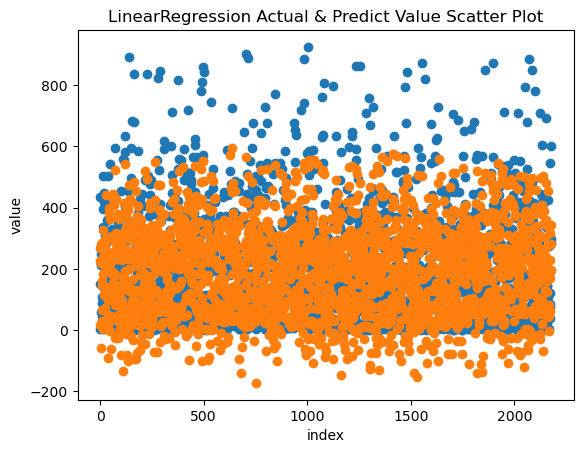

2753895322727.0625


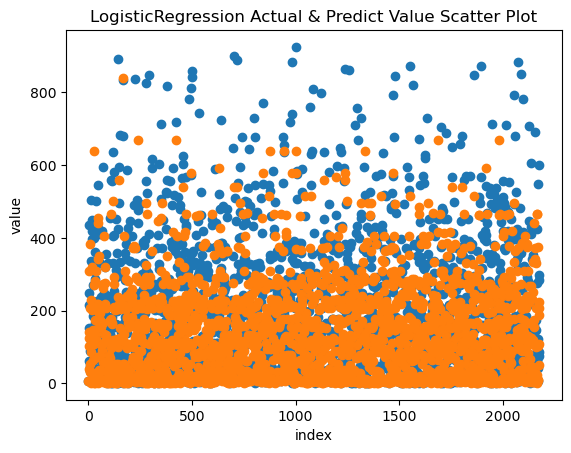

144.7221422988886


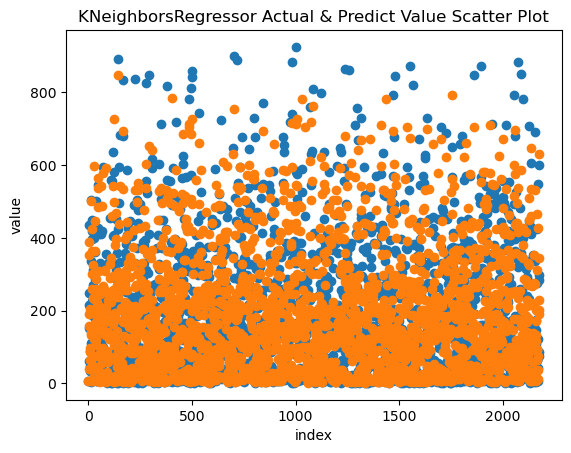

84.72586439494998


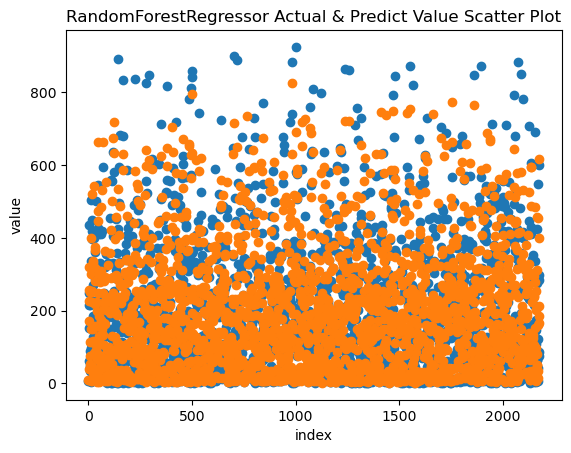

76.67843298246062


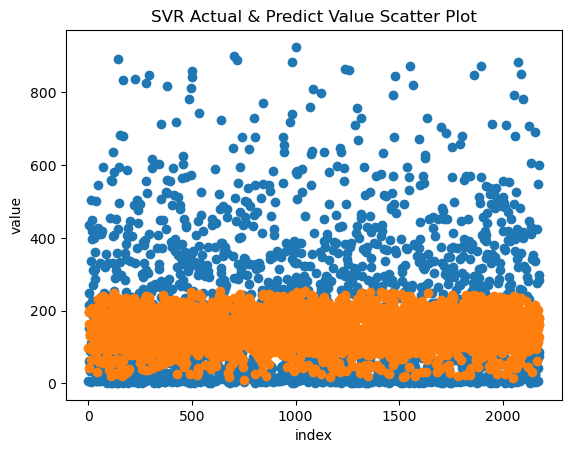

160.2237542324823


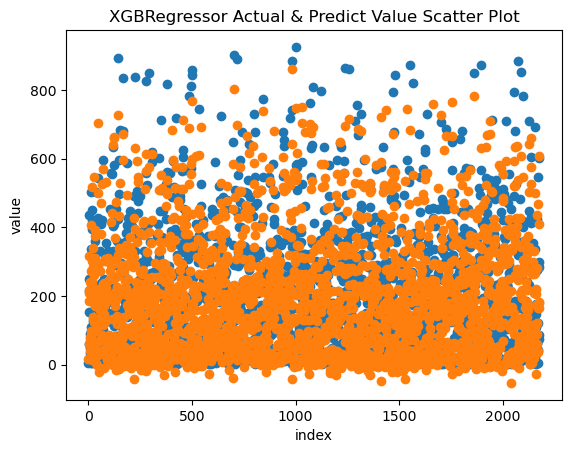

74.1038441600677


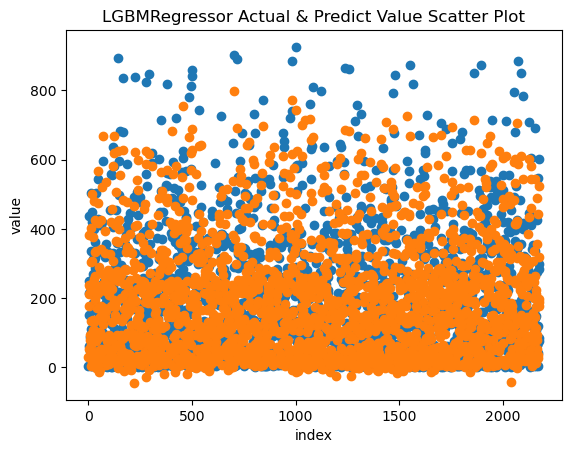

71.13729546956513


In [227]:
model_lst = [lir_model, lor_model, knn_model, rf_model, svr_model, xgb_model, lgb_model]
rmse_lst = [r_score_lir, r_score_lor, r_score_knn, r_score_rf, r_score_svr, r_score_xgb, r_score_lgb]

for model, rmse in zip(model_lst, rmse_lst):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)

    res = pd.DataFrame({'y_val':y_val, 'pred':pred}).reset_index(drop=True)
    plt.scatter(x=res.index, y=res['y_val'])
    plt.scatter(x=res.index, y=res['pred'])
    plt.xlabel('index')
    plt.ylabel('value')
    if len(str(model)) < 50:
        plt.title(f'{str(model)[:-2]} Actual & Predict Value Scatter Plot')
    else:
        plt.title(f'{str(model)[:12]} Actual & Predict Value Scatter Plot')
    plt.show()
    
    # evaluate_regr(y_val, pred)
    print(rmse.mean())

- Linear Regression의 평균 rmse는 굉장히 높게 나왔는데 음수로 예측하는 값 때문에 그렇지 않을까 추측한다.
- 평균 RMSE를 봤을 때, LGBM이 가장 좋은 성능을 보였고 그 다음은 XGBoost였다.
- Feature Importance, 다중공선성, parameter tuning을 고려하면 더 좋은 성능을 낼 수 있을 듯 하다.